In [4]:
#Import necessary libraries and modules from TensorFlow and Keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.preprocessing import sequence

In [5]:
#Download and extract the IMDB dataset.

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9244k      0  0:00:08  0:00:08 --:--:-- 16.8M


In [6]:
#Define the maximum number of features and the maximum length of sequences

max_features = 10000
maxlen = 150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Custom layer representing one layer of a transformer encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)

#Dense projection network
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

#Define how inputs are processed by the layer
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

 #Serialize the layer's configuration
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [8]:
#Define parameters for the Transformer encoder layer

vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32


#Defined a model architecture using an embedding layer followed by a Transformer encoder layer and other dense layers.
#Compiling the model with optimizer, loss function, and metrics

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,664,033 (21.61 MB)

 Trainable params: 5,664,033 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

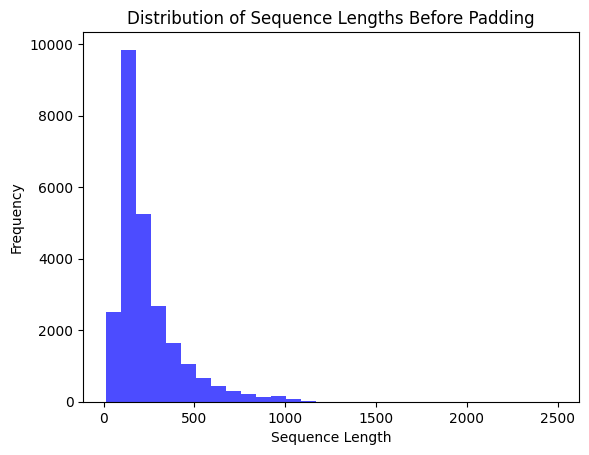

In [9]:
# Visualize sequence lengths before padding
import matplotlib.pyplot as plt

# Visualize sequence lengths before padding
sequence_lengths = [len(seq) for seq in imdb.load_data(num_words=max_features)[0][0]]

plt.hist(sequence_lengths, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Sequence Lengths Before Padding")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

In [10]:
import string

#Defining a class Vectorizer with a method "standardize" to preprocess text by converting it to lowercase and removing punctuation.
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

In [11]:
#Define a method "tokenize"

def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

In [12]:
#creating a vocabulary from the dataset through a method "make_vocabulary"

def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

In [13]:
#Defining a method "encode" to encode text using the created vocabulary

def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

In [14]:
#Decoding integer sequences back to text

def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

In [15]:
import re
import string
import tensorflow as tf

In [16]:
#Using a custom standardization function for text preprocessing using TensorFlow

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

In [17]:

#Using a custom split function for text preprocessing

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

In [18]:
#Removing the unsupervised training data directory, displaying the content of a positive review file

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup
!cat aclImdb/train/pos/4077_10.txt
import os, pathlib, shutil, random

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9208k      0  0:00:08  0:00:08 --:--:-- 16.9M
I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drin

In [19]:
#Defining batch size and directories for the dataset

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

In [20]:
#Moving a portion of training data to the validation directory for each category
#Here, I am making sure the directory and file exist

for category in ("neg", "pos"):

    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:

        if not os.path.exists(val_dir / category / fname):
            shutil.move(train_dir / category / fname,
                        val_dir / category / fname)

In [21]:
from tensorflow import keras
batch_size = 32

In [22]:
#Creating TensorFlow datasets for training, validation, and testing

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [23]:
#Displaying the shapes and dtypes of the first batch

for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'"Freddy\'s Dead" did the smartest thing it could\'ve done after the disappointment of the fifth film. It started from scratch. Sure, this "final" film in the saga is silly but at least it\'s original. Some of the visuals are even a bit breath-taking. And the story of Freddy\'s kid (Lisa Zane) returning to town to face her evil father is unique.<br /><br />Overall, the movie is nothing but another cartoon made to get kids in the theater. It has a bunch of good actors (Zane, Yaphet Kotto, and Lezlie Deane) who basically look dumb and wander around like sheep ready for slaughter. It\'s one-sided, it\'s a magic-trick, and, in the end, it\'s nothing but goofy, childish entertainment.<br /><br />', shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [24]:
from tensorflow.keras.layers import TextVectorization

In [25]:
#Creating a dataset containing only text inputs for training

text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [26]:
#Using the text_vectorization function to convert text data into binary 1-gram representations

#Here, the use of "num_parallel_calls=4" argument indicates mapping done in parallel using four threads

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [27]:
#Data Exploration in binary_1gram_train_ds

for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([0 1 1 ... 0 0 0], shape=(20000,), dtype=int64)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [28]:
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
#Function to Build and Compile a Feedforward Neural Network Model
#max_tokens (int) indicates maximum number of tokens in each input, while sequence.hidden_dim (int) indicates dimensionality of the hidden layer.

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [30]:
#Creating and summarizing a simple dense model.

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │         320,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,033 (1.22 MB)

 Trainable params: 320,033 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#Training the model using the integer encoded training and validation dataset

model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

#Loading the model and evaluating its performance on the test dataset
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7682 - loss: 0.4865 - val_accuracy: 0.8900 - val_loss: 0.2794
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8897 - loss: 0.2873 - val_accuracy: 0.8930 - val_loss: 0.2818
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9116 - loss: 0.2463 - val_accuracy: 0.8946 - val_loss: 0.2955
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9147 - loss: 0.2313 - val_accuracy: 0.8934 - val_loss: 0.3122
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9243 - loss: 0.2155 - val_accuracy: 0.8926 - val_loss: 0.3245
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9302 - loss: 0.2118 - val_accuracy: 0.8884 - val_loss: 0.3497
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9331 - loss: 0.2064 - val_accuracy: 0.8924 - val_loss: 0.3482
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9367 - loss: 0.2020 - val_accuracy: 

In [32]:
#Configuring TextVectorization Parameters

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

In [33]:
#Training and testing the binary bigram model

text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [34]:
#Initializing Model and Setting Up Checkpoints

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │         320,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,033 (1.22 MB)

 Trainable params: 320,033 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#Training the Model and Evaluating Test Accuracy

model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7779 - loss: 0.4684 - val_accuracy: 0.8976 - val_loss: 0.2642
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9046 - loss: 0.2623 - val_accuracy: 0.8988 - val_loss: 0.2661
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9259 - loss: 0.2098 - val_accuracy: 0.8974 - val_loss: 0.2878
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9390 - loss: 0.1975 - val_accuracy: 0.8970 - val_loss: 0.3077
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9445 - loss: 0.1841 - val_accuracy: 0.8946 - val_loss: 0.3186
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9498 - loss: 0.1770 - val_accuracy: 0.8946 - val_loss: 0.3242
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9538 - loss: 0.1738 - val_accuracy: 0.8940 - val_loss: 0.3412
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9532 - loss: 0.1590 - val_accuracy: 

In [37]:
#Configuring the TextVectorization layer to return token counts

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

In [36]:
#Configuring TextVectorization to return TF-IDF-weighted outputs

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

In [38]:
#Training and testing the TF-IDF bigram model

text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


In [39]:
#Initializing the Model and Summary
model = get_model()
model.summary()

#Model Checkpoint Configuration
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │         320,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,033 (1.22 MB)

 Trainable params: 320,033 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#Model Training and Evaluation on Test Data

model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7295 - loss: 0.5449 - val_accuracy: 0.8704 - val_loss: 0.3144
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8814 - loss: 0.2999 - val_accuracy: 0.8880 - val_loss: 0.2847
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9007 - loss: 0.2573 - val_accuracy: 0.8864 - val_loss: 0.3006
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9107 - loss: 0.2274 - val_accuracy: 0.8902 - val_loss: 0.3000
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9195 - loss: 0.2156 - val_accuracy: 0.8940 - val_loss: 0.2943
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9244 - loss: 0.2041 - val_accuracy: 0.8892 - val_loss: 0.3156
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9238 - loss: 0.2015 - val_accuracy: 0.8938 - val_loss: 0.3161
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9286 - loss: 0.1916 - val_accuracy: 0

In [41]:
#Model Inference and Prediction

inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

90.10 percent positive


In [42]:
#Processing words as a sequence: The sequence model approach

#Downloading the data

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9080k      0  0:00:09  0:00:09 --:--:-- 15.3M


In [43]:
#Preparing the data

import os, pathlib, shutil, random
from tensorflow import keras

In [44]:
#Setting up directories

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

In [45]:
for category in ("neg", "pos"):
    # Check if the directory already exists
    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        # Check if the file already exists in the destination directory
        if not os.path.exists(val_dir / category / fname):
            shutil.move(train_dir / category / fname,
                        val_dir / category / fname)

In [46]:
#Creating Datasets from Directories

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [47]:
#Preparing integer sequence datasets

from tensorflow.keras import layers

In [48]:
#Text Vectorization: Initialization and Adaptation

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

In [49]:
#Integer Encoding Mapping for Datasets

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [50]:
#A sequence model built on one-hot encoded vector sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



class OneHotEncodingLayer(layers.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        return tf.one_hot(inputs, depth=self.depth)

inputs = keras.Input(shape=(None,), dtype="int64")
# Wrap tf.one_hot in a custom layer
embedded = OneHotEncodingLayer(depth=max_tokens)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [51]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ one_hot_encoding_layer               │ (None, None, 20000)         │               0 │
│ (OneHotEncodingLayer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │       5,128,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,128,513 (19.56 MB)

 Trainable params: 5,128,513 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
#Creating a simple neural network model for binary classification tasks to specify the maximum number of input tokens and the size of the hidden layer

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [53]:
# Define the model
model = get_model()

In [54]:
#Callback for Model Checkpointing

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

In [55]:
import os
import random
import shutil
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [56]:
# Define the base directory
base_dir = pathlib.Path("aclImdb")

In [57]:
# Define the directories for train, validation, and test sets
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

In [58]:
# Create directories for validation set
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname, val_dir / category / fname)

In [59]:
#Data Preparation for Text Classification

batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset="training", seed=1337
)
val_ds = keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset="validation", seed=1337
)
test_ds = keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size
)


Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Found 25000 files belonging to 2 classes.


In [60]:
#Defining the TextVectorization layer
max_features = 20000
sequence_length = 600

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)


In [61]:
#Adapting the TextVectorization layer on the training dataset
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


In [62]:
#Define the model
embedding_dim = 128
model = keras.Sequential([
    vectorize_layer,
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [63]:
#Compile the model
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [64]:
#Train the model
model.fit(train_ds, validation_data=val_ds, epochs=10)

#Evaluate the model
print("Evaluate on test data")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 381s 750ms/step - accuracy: 0.5212 - loss: 0.6725 - val_accuracy: 0.8090 - val_loss: 0.4231
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 383s 753ms/step - accuracy: 0.8390 - loss: 0.3657 - val_accuracy: 0.8518 - val_loss: 0.3870
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 378s 745ms/step - accuracy: 0.9106 - loss: 0.2314 - val_accuracy: 0.8800 - val_loss: 0.3182
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 373s 746ms/step - accuracy: 0.9430 - loss: 0.1631 - val_accuracy: 0.8742 - val_loss: 0.3789
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 387s 757ms/step - accuracy: 0.9628 - loss: 0.1133 - val_accuracy: 0.8683 - val_loss: 0.4236
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 412s 823ms/step - accuracy: 0.9728 - loss: 0.0833 - val_accuracy: 0.8648 - val_loss: 0.4628
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 393s 787ms/step - accuracy: 0.9833 - loss: 0.0552 - val_accuracy: 0.8600 - val_loss: 0.6358
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 463s 829ms/step - accuracy: 0.9642 -

In [65]:
max_tokens = 20000  # Defining the maximum number of tokens in your vocabulary
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [66]:
#Model definition with embedding layer for text classification

embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [67]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,194,049 (19.81 MB)

 Trainable params: 5,194,049 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
#Directory paths for training, validation, and test data

train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"


In [69]:
#Model architecture definition with embedding layer, bidirectional LSTM, dropout, and dense layer

embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [70]:
#Model input and layers configuration: embedding, bidirectional LSTM, dropout, and dense layers

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [71]:
#Model compilation with RMSprop optimizer, binary crossentropy loss, and accuracy metric

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])


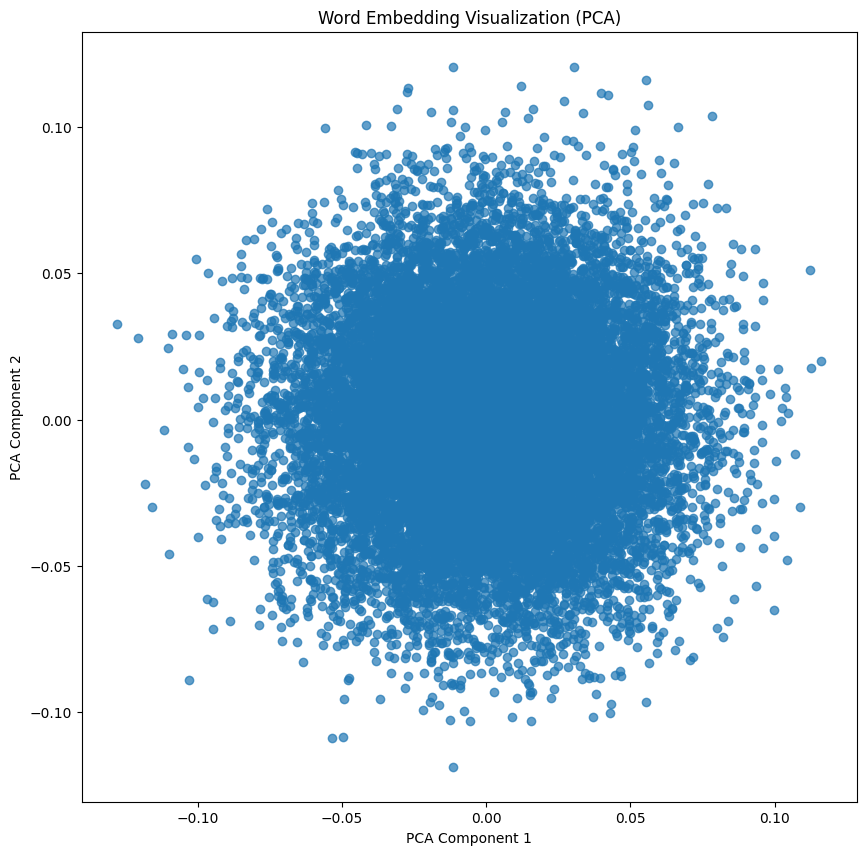

In [72]:
#  Word Embedding Visualization
from sklearn.decomposition import PCA

# Extract embeddings from the Embedding layer (index 1, not 0)
embedding_matrix = model.layers[1].get_weights()[0]  # Changed from layers[0] to layers[1]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
plt.title("Word Embedding Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()